## MILP Approach for Small Instances

fixed cost first echelon vehicles - 100  
fixed cost second echelon vehicles - 50

In [1]:
import pandas as pd

data = pd.read_excel("Data\Instances\Small_Instances.xlsx", sheet_name='A1', index_col=0)
data = data[['X', 'Y']]

solution_variables = pd.read_excel('solution.xlsx', index_col=0)

In [2]:
data.head()

,X,Y
Number,,
1,47.416821,53.807242
2,13.439768,8.259892
3,35.115685,44.278523
4,17.539752,23.700627
5,37.094541,19.816419


In [3]:
solution_variables.head()

,value
"R_ij_t[1,5,2]",1.0
"R_ij_t[2,4,1]",1.0
"R_ij_t[3,1,2]",1.0
"R_ij_t[4,6,1]",1.0
"R_ij_t[5,3,2]",1.0


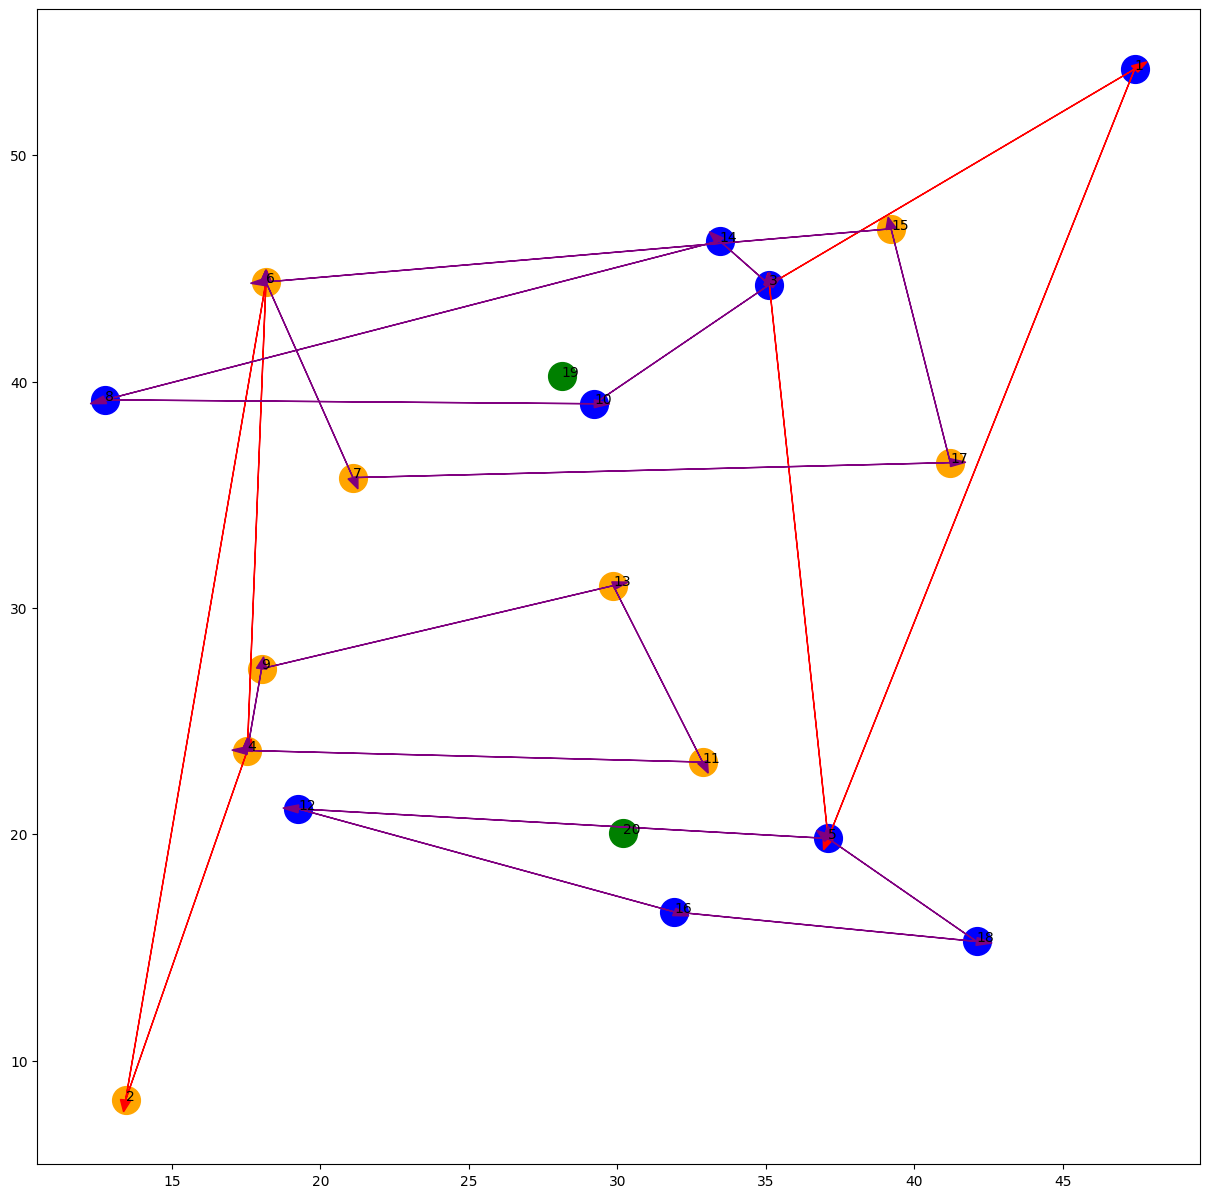

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

# plot depots [1, 2]
plt.scatter(data['X'][1], data['Y'][1], color='blue', label='Depot', s=400)
plt.scatter(data['X'][2], data['Y'][2], color='orange', label='Depot', s=400)

# plot satellites [3, 4, 5, 6] (3, 5 belong to LSP 1, 4, 6 belong to LSP 2)
plt.scatter(data['X'][3], data['Y'][3], color='blue', label='Satellite', s=400)
plt.scatter(data['X'][4], data['Y'][4], color='orange', label='Satellite', s=400)
plt.scatter(data['X'][5], data['Y'][5], color='blue', label='Satellite', s=400)
plt.scatter(data['X'][6], data['Y'][6], color='orange', label='Satellite', s=400)

# plot customers [7-18] (even numbers belong to LSP 1, odd numbers belong to LSP 2) (colour according to LSP)
for i in range(7, 19):
    if i % 2 == 0:
        plt.scatter(data['X'][i], data['Y'][i], color='blue', label='Customer', s=400)
    else:
        plt.scatter(data['X'][i], data['Y'][i], color='orange', label='Customer', s=400)

# plot collaboration points [19, 20]
plt.scatter(data['X'][19], data['Y'][19], color='green', label='Collaboration Point', s=400)
plt.scatter(data['X'][20], data['Y'][20], color='green', label='Collaboration Point', s=400)

# plt.scatter(data['X'], data['Y'], color='blue')
for i in data.index:
    plt.annotate(i, (data['X'][i], data['Y'][i]), color='black')


# first-echelon
for variable_name in solution_variables.index:
    if variable_name[0] == 'R':
        point_a = int(variable_name[7])
        point_b = int(variable_name[9])
        plt.arrow(data['X'][point_a], data['Y'][point_a], data['X'][point_b] - data['X'][point_a], data['Y'][point_b] - data['Y'][point_a], color='red',
          head_width=0.35)
        
# second-echelon
for variable_name in solution_variables.index:
    if variable_name[0] == 'X':
        point_a = int(variable_name.split(',')[0].split('[')[-1])
        point_b = int(variable_name.split(',')[1])
        plt.arrow(data['X'][point_a], data['Y'][point_a], data['X'][point_b] - data['X'][point_a], data['Y'][point_b] - data['Y'][point_a], color='purple',
          head_width=0.35)